<a href="https://colab.research.google.com/github/idan424/AccuLine-noisy-ECG-classification-assignment/blob/main/Using_The_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Change to our data directory
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/AccuLine Assignment/DATA')

In [14]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()
xgb_model.load_model('../XGBclassifier.json')

In [15]:
import numpy as np

# Load data
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Switch labels so that noisy == 1
y_test = (y_test == 0).astype(int)

In [16]:
#@title This is the new data pipeline

#@markdown here we cut the signal to 10 second intervals and downsample it to 100 Hz so it fits the model's input size
from scipy.signal import resample

def preprocess_signal(signal, s_freq=100):
    """
        This function gets a signal and sampling frequency and returns it cut
        to 10 sec intervals at 100 Hz sampling rate.

        params:
        signal: np.ndarray
        s_freq: int
    """
    # cut to 10 sec segments
    samples_per_signal = 10 * s_freq
    signal = signal[:, :(signal.shape[1] // samples_per_signal) * samples_per_signal]
    signals = signal.reshape(-1, samples_per_signal)

    # resample to 100 Hz
    signals = resample(signals, 1000, axis=1)

    # normalise signals - this might be better put in the beggining of this function
    eps = 1e-9
    min_max_normalize = lambda X: (X - X.min(axis=1)[:,None]) / ((X.max(axis=1) - X.min(axis=1)) + eps)[:, None]

    signals = min_max_normalize(signals)

    return signals




In [18]:
# prompt: i want you to write a function that recieves a signal and predicts if it's noisy or not

def predict_noise(signal):
    """
    This function takes a signal and predicts if it's noisy or not.

    Args:
        signal: A numpy array containing the signal data.

    Returns:
        A numpy array containing the predictions (0 for non-noisy, 1 for noisy).
    """

    # Preprocess the signal
    signal = preprocess_signal(signal)


    # Make predictions using the XGBoost model
    predictions = xgb_model.predict(signal)

    # Convert the predictions to binary values (0 or 1)
    predictions = (predictions > 0.5).astype(int)

    return predictions

y_pred_test = predict_noise(X_test)

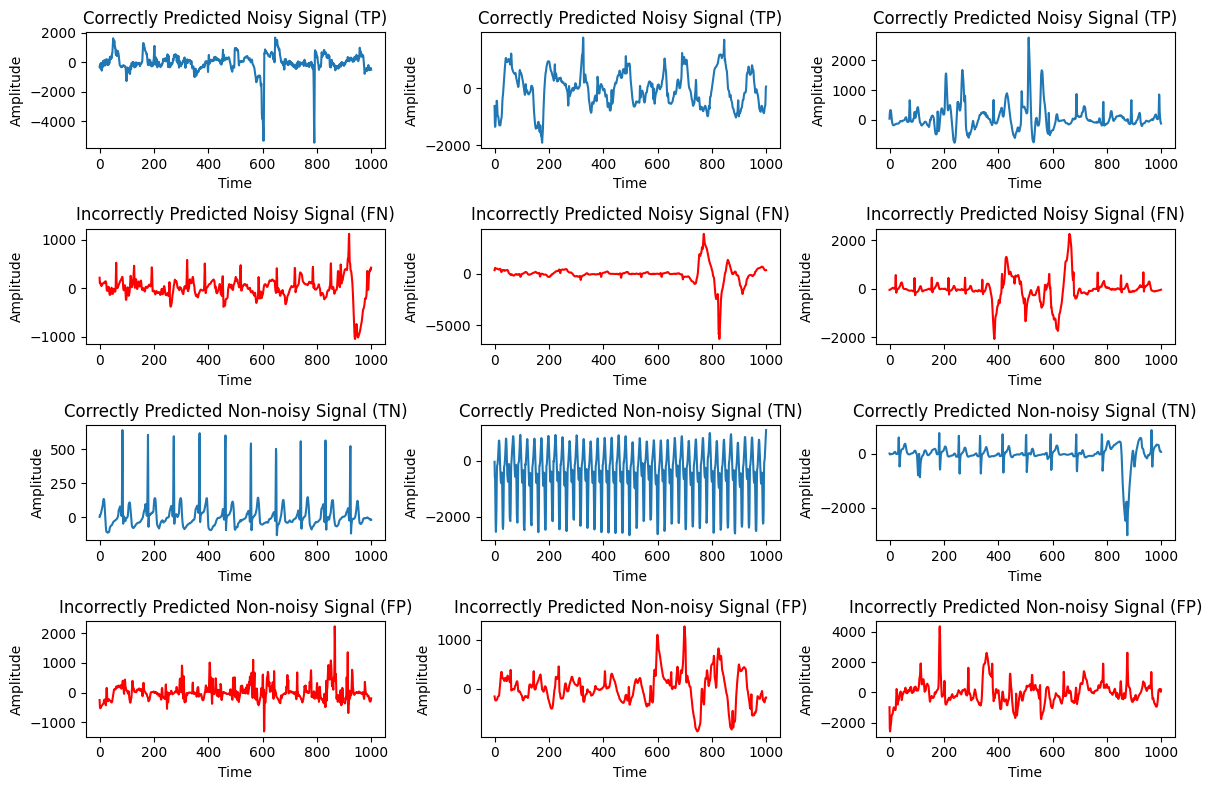

In [43]:
#@title Show prediction results sample {run:'auto'}
import matplotlib.pyplot as plt

# Choose samples for plotting
correct_noisy_samples = []
correct_clean_samples = []
incorrect_noisy_samples = []
incorrect_clean_samples = []

for i in range(len(y_test)):
    if y_pred_test[i] == y_test[i]:
        if y_pred_test[i] == 1:  # Correctly predicted as noisy
            correct_noisy_samples.append(i)
        else:  # Correctly predicted as clean
            correct_clean_samples.append(i)
    else:
        if y_pred_test[i] == 1:  # Incorrectly predicted as noisy
            incorrect_noisy_samples.append(i)
        else:  # Incorrectly predicted as clean
            incorrect_clean_samples.append(i)

# just for fun
np.random.shuffle(correct_noisy_samples)
np.random.shuffle(correct_clean_samples)
np.random.shuffle(incorrect_noisy_samples)
np.random.shuffle(incorrect_clean_samples)

# Plotting
plt.figure(figsize=(15, 8))
n_signals = 3 # @param {type:"slider", min:1, max:3, step:1}

# Plot correct noisy samples
for i, idx in enumerate(correct_noisy_samples[:n_signals]):
    plt.subplot(4, n_signals, i + 1)
    plt.plot(X_test[idx])
    plt.title("Correctly Predicted Noisy Signal (TP)")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

# Plot incorrect noisy samples
for i, idx in enumerate(incorrect_noisy_samples[:n_signals]):
    plt.subplot(4, n_signals, i + n_signals + 1)
    plt.plot(X_test[idx], c='red')
    plt.title("Incorrectly Predicted Noisy Signal (FN)")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

# Plot correct clean samples
for i, idx in enumerate(correct_clean_samples[:n_signals]):
    plt.subplot(4, n_signals, i + 2*n_signals+1)
    plt.plot(X_test[idx])
    plt.title("Correctly Predicted Non-noisy Signal (TN)")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

# Plot incorrect clean samples
for i, idx in enumerate(incorrect_clean_samples[:n_signals]):
    plt.subplot(4, n_signals, i + 3 * n_signals + 1)
    plt.plot(X_test[idx], c='red')
    plt.title("Incorrectly Predicted Non-noisy Signal (FP)")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


It seems like the model has learned to detect noisy signals pretty good

We can se that the incorrectly predicted Non-noisy signals look actually pretty noisy

It does seem that the model knows how a "clean" signal looks like



---

>Given the data it seems that in a 10-sec resolution, the results are not accurate if I judge by eye, there are noisy segments in clean recordings an vice versa
>
>A design with finer resolution and labeling should provide more accurate results in the future

>We used an XGBoost architecture, this is a POC choice and does not represent the end model for this task

>Since this is a time series modeling problem, a more signal processy aproach should be investigated as well - CNN, RNN, fourier series based regression or DNN to name a few.
